In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from approval_matrix import plot_approval_matrix
from models import cross_val_pr_curve,tune_hyperparameters

In [2]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [3]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':['balanced']
}

best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,RandomForestClassifier(),'average_precision')

print("Best Hyperparameters for RnadomForest Regression:", best_params)


Best Hyperparameters for RnadomForest Regression: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [4]:
# Train RandomForest Regression model with best hyperparameters
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.93725375 0.93818363 0.93834756]
Mean Precision Score: 0.937928314540699
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.62      0.69      5654
           1       0.87      0.93      0.90     15952

    accuracy                           0.85     21606
   macro avg       0.82      0.78      0.79     21606
weighted avg       0.84      0.85      0.84     21606



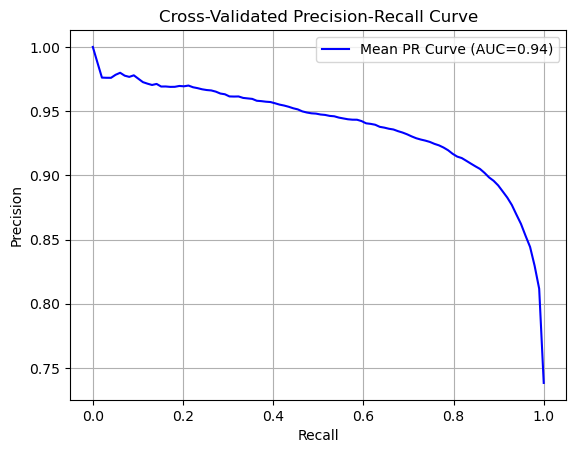

Mean Precision-Recall AUC: 0.9394


In [5]:
from models import evaluate_models
evaluate_models(rf_model, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


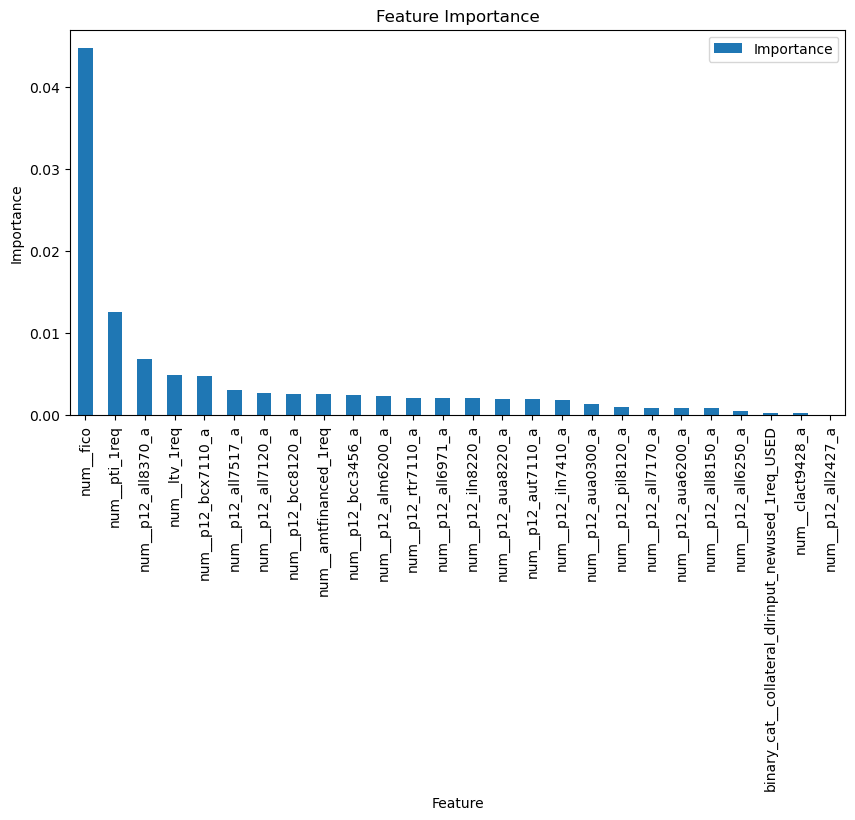

In [6]:
from models import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(rf_model, X_train_processed, y_train,'average_precision')

In [7]:
y_pred_rf_test = rf_model.predict(X_test_processed)

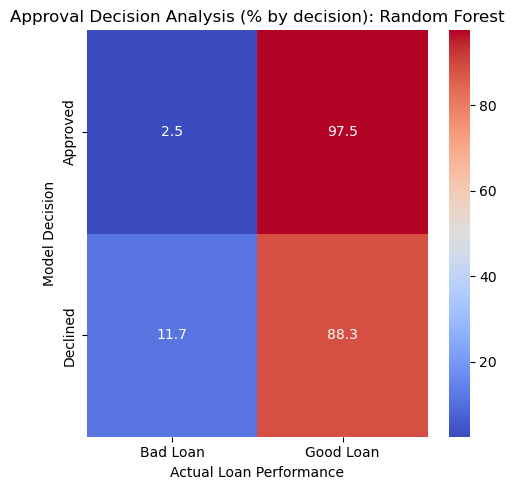

In [8]:
plot_approval_matrix(y_pred_rf_test,pd.read_csv(test_data_path)['bad_flag'], 'Random Forest')

In [9]:
print("Random Forest model approval rate: ", y_pred_rf_test.mean())

Random Forest model approval rate:  0.7783333333333333


In [10]:
gender_aprv = pd.DataFrame({'Gender': pd.read_csv(test_data_path)['Gender'], 'Model_Aprv': y_pred_rf_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.783069,0.737654
Male,0.778281,0.749739
Undefined,0.737452,0.683398


In [11]:
race_aprv = pd.DataFrame({'Race': pd.read_csv(test_data_path)['Race'], 'Model_Aprv': y_pred_rf_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
race_aprv.groupby(['Race']).mean()

,Model_Aprv,True_Aprv
Race,,
Asian,0.820144,0.755396
Black,0.778082,0.724658
Hispanic,0.747961,0.721044
Other,0.756032,0.718499
White,0.791951,0.756480
